**Aircraft Maneuver Classification - ECE 585 Final Project**

Presentation can be accessed on [Google Slides](https://docs.google.com/presentation/d/10J6vTPsUq62TtRZ7oYi57m2hXeUFvvb2dLv9yPxUBLg/edit?usp=sharing).

# Background

USAF Pilot Training Pipeline is currently backloged due to staffing issues. To maintain mission readiness, flight simulators have replaced flight hours. Due to the increase flight simulators, instructors are working longer hours. This is potentially dangerous as the student's and instructor's attitude towards simulators is lax compared to traditional flights. Therefore, having an AI pipeline which can analyze student flying in real time and grade them accordingly is of increased importance. Not only will this serve as a check for instructors, but allows for students to train on the simulators in absence of an instructor.

#Introduction

## Data

The data avilable for this project is TSV files which contain eleven (11) features:

*   Index
*   Time
*   X Position
*   Y Position
*   Z Position
*   X Velocity
*   Y Velocity
*   Z Velocity
*   Heading
*   Pitch
*   Roll

The data provided is a dump of the simulator data. Therefore there is a signifigant amount of artifacts. In addition, most of the data is straight, level, unaccelerated flight (SLUF). This is not interesting for the discussion at hand, as the problem set is for identify, classifing, and grading maneuvers.

## Pipeline Theory

To implement a solution, we can break the problem down into the following pipeline:

1.   Identify maneuvers from data to create a maneuvers dataset
2.   Peform classification on the maneuvers dataset.
3.   Utilize sorted maneuvers to create a generative model to simulate maneuvers at a variety of skill levels
4.   Trian classification model to predict skill level with synthetic maneuvers
5.   Execute classification model on sorted maneuvers, thus providing a 'grade'

For this project, we will focus on part one (1) of this pipeline, as it directly relates to the material learned in this course.

## Proposal: Maneuver Seperation

To seperate the maneuvers from the TSV files, we first need to extract at what points the data moves from artificat to non-artificat or maneuver to SLUF. One method we can implement to solve this problem is Change Point Detection.

Change Point Detection (CPD) is a problem set which attempts to identify when a generating distribution changes based off some observable data. More information on CPD can be found [here](https://en.wikipedia.org/wiki/Change_detection).

To implement CPD, we must first have a metric to compare our methods against. It is important that we obtain the the entiriety of the maneuver period. In other words, we are willing to have a higher false alarm rate if it means a lower misdetection rate.

Still, we do not have a method to actually implement this metric. We need true data to test different models. One way to obtain true data is to generate synthetic data. This is the approach we will take here

# Sortie Generation

To create a generator, we will take our exemplatory examples and stich them together in random order at random intervals to obtain generated sorties. Some issues with this method is future models could pick up on the same data being utilized, which would cause issues. Further, the frequency of maneuvers may not accurately reflect the frequency of maneuvers in the real data. The authors aknowledge these limitions and will keep them in note during analayis. However, it is unlikey they these issues will be of signifance as the impact to the overaching distribution is small compared to the maneuvers themselves.

## Data Generations Steps

In order to actually generate the data, certain steps must be taken.

1.   Ensure exmplatory data is sufficent
2.   Randomly select maneuvers and record selection time
3.   Concatanate maneuvers together
    *   Change heading to reflet heading of previous maneuvers
    *   Change speed to ensure ending speed of previous maneuver matches starting speed of new maneuver
    *   Change position ensure continuous positional data.

The code below generates the sortie with random maneuvers at random intervals.

In [1]:
from scipy.spatial.transform import Rotation
import datetime
import numpy as np
import pandas as pd
import os

np.random.seed(99)

#Not required, but helps easily check to see if data is synthetic
def clean_data(df, round_to=4):
  #Convert index to datetime
  df['time'] = pd.to_datetime(df['time'], unit="s")
  df.drop(["idx"], axis=1, inplace=True)
  df.set_index('time', inplace=True)

  #Impute Data
  resampled_data = df.resample('100ms').asfreq()
  merged_data = pd.concat([df, resampled_data])
  clean_interpolation = round(merged_data.sort_values('time').interpolate("linear"), round_to)
  clean_interpolation = clean_interpolation[~clean_interpolation.index.duplicated(keep='first')]
  very_clean_data = clean_interpolation.drop(df.index.values).iloc[1:]

  #Add back in standard IDX and time
  time_in_sec = (very_clean_data.index - datetime.datetime(1970,1,1)).total_seconds()
  very_clean_data = very_clean_data.reset_index()
  very_clean_data["time"] = time_in_sec - min(time_in_sec)
  very_clean_data["time"] = round(very_clean_data["time"],2)
  very_clean_data.insert(0, 'idx', very_clean_data.index)

  #Zero out position
  very_clean_data["x"] = very_clean_data["x"] - very_clean_data["x"].iloc[0]
  very_clean_data["y"] = very_clean_data["y"] - very_clean_data["y"].iloc[0]
  very_clean_data["z"] = very_clean_data["z"] - very_clean_data["z"].iloc[0]

  #Zero out heading
  very_clean_data = rotate_maneuver(very_clean_data, very_clean_data["heading"].iloc[0])

  return very_clean_data

#Rotates maneuver required time step
#passed by reference
def rotate_maneuver(df, rot_angle):
  #Correct heading angle
  df[["heading"]] = (df[["heading"]] - rot_angle)%360
  # Create a rotation to match the previous heading
  r = Rotation.from_euler('z', rot_angle, degrees=True)
  new_pos = r.apply(df[["x","y","z"]])
  new_vel = r.apply(df[["xVel", "yVel", "zVel"]])
  df[["x","y","z"]] = new_pos
  df[["xVel", "yVel", "zVel"]] = new_vel
  return df

def concat_maneuvers(man1, man2, time_to_add=2, sampling_frequency=0.1):
  #Rotate Maneuver and add position data to match prev end point
  rotate_maneuver(man2, -man1["heading"].iloc[-1])

  #Create some blank 'carryover' to help bridge the gap between samples
  rows_to_add = int(time_to_add*(1/sampling_frequency))
  last_idx = int(man1['idx'].iloc[-1])

  na_df = pd.DataFrame({'time': [man1['time'].iloc[-1] + (sampling_frequency * i) for i in range(1, rows_to_add + 1)]})
  na_df['idx'] = range(last_idx +1, last_idx + rows_to_add + 1)

  impute_df =  pd.concat([man1, na_df, man2], ignore_index=True)

  #impute velocities and angles
  impute_df[["xVel", "yVel", "zVel", "pitch", "roll", "heading"]] = impute_df[["xVel", "yVel", "zVel", "pitch", "roll", "heading"]].interpolate(method='polynomial', order=3)

  #get rid of M2
  impute_df = impute_df.iloc[:last_idx + rows_to_add]

  #Iteritvely Update Position

  #Locate previous position
  last_x = man1["x"].iloc[-1]
  last_y = man1["y"].iloc[-1]
  last_z = man1["z"].iloc[-1]

  for i in range(last_idx+1, last_idx + rows_to_add):
    #Calculate new position
    new_x_value = impute_df["xVel"].iloc[i] * sampling_frequency + last_x
    new_y_value = impute_df["yVel"].iloc[i] * sampling_frequency + last_y
    new_z_value = impute_df["zVel"].iloc[i] * sampling_frequency + last_z

    #Update in df
    impute_df.at[i, "x"] = new_x_value
    impute_df.at[i, "y"] = new_y_value
    impute_df.at[i, "z"] = new_z_value

    #save new pos
    last_x = new_x_value
    last_y = new_y_value
    last_z = new_z_value

  #Correct time on M2
  man2[["time", "idx", "x","y","z"]] = man2[["time", "idx", "x","y","z"]] + impute_df[["time", "idx", "x","y","z"]].iloc[-1]

  return pd.concat([impute_df , man2], ignore_index=True)

#Return synthetic sortie and change point segements
def generate_sortie (sortie_length_sec, maneuvers, p=None, sampling_rate=0.1):
    #if p is float it indiciates probability of SLUF
    if type(p) is float:
        p_array = ((1-p)/(len(maneuvers)-1)) * np.ones(len(maneuvers))
        p_array[0] = p
        p = p_array

    #Ensures we start at SLUF
    synthetic_sortie = maneuvers[0]
    maneuver_choices = [0]
    generated_length = maneuvers[0]["time"].iloc[-1]
    change_times = [generated_length]


    while generated_length <= sortie_length_sec:
        # Randomly selects maneuver to accomplish and logs result
        cman_idx = np.random.choice(len(maneuvers), p=p)

        #Calculate 'transition time' between maneuvers
        norm = np.linalg.norm(synthetic_sortie[["xVel","yVel","zVel"]].iloc[-1] - maneuvers[cman_idx][["xVel","yVel","zVel"]].iloc[0], ord=2)
        time_between = int(norm)/10

        #Concat Sortie
        synthetic_sortie = concat_maneuvers(synthetic_sortie.copy(), maneuvers[cman_idx].copy(), time_to_add=time_between)

        #Log choice
        generated_length = synthetic_sortie["time"].iloc[-1]

        #Transition Phase
        if time_between:
          maneuver_choices.append(-1)
          change_times.append(change_times[-1] + time_between)

        #Raw Choice Phase
        maneuver_choices.append(cman_idx)
        change_times.append(generated_length)
    change_times.pop()
    return synthetic_sortie, change_times, maneuver_choices

In [2]:
import pandas as pd
import os

#load in required files data
sample_maneuvers_fn = os.listdir("./samples")
sample_maneuvers_fn.remove("SLUF.tsv")
sample_maneuvers_fn.insert(0, "SLUF.tsv")
# sample_maneuvers_fn.remove(".ipynb_checkpoints")

col_names = ["idx", "time", "x", "y", "z", "xVel", "yVel", "zVel", "pitch", "heading", "roll"]

maneuvers = [clean_data(pd.read_csv("./samples/" + fn, sep='\t', skiprows=[0], names=col_names)) for fn in sample_maneuvers_fn]
maneuver_names = [fn.split("_")[-1].split(".")[0] for fn in sample_maneuvers_fn]

In [27]:
# [len(i) for i in maneuvers]
# maneuvers
modified_sortie, true_ranges = obtain_sortie(transition="maneuver")
modified_sortie

,speed,pitch,roll,partial_heading,maneuver
0,103.045807,-5.7320,-4.3898,-1.086,0
1,103.146513,-4.7983,-4.4412,-1.333,0
2,103.247224,-3.7060,-4.6415,-1.477,0
3,103.349550,-2.7058,-4.8574,-1.626,0
4,103.454068,-1.7202,-5.0413,-1.740,0
...,...,...,...,...,...
1228,111.572800,-1.3650,-2.0343,-0.286,0
1229,111.704968,-1.2865,-1.9355,-0.157,0
1230,111.841662,-1.2033,-1.8285,-0.049,0
1231,111.975849,-1.1414,-1.7217,0.062,0


In [3]:
#example Usage
sortie_data, change_points, maneuver_choices = generate_sortie(120, maneuvers, p=0.4)
sortie_data.to_csv(f'generated_sample.tsv', sep='\t', index=False)

# Feature Extraction

At this point, our data looks structurally simmilar to our observed data, but we have known change points. In order to perform change point detection, we will extract the features that we beleive to be relevant. In this case, the x,y,z positions and x,y,z velocities are not relevant as they are not in reference the the aircraft, rather they are in reference the the global positioning. For example, it makes no difference the x,y,z coordinates that a pilot performs the maneuver. This same logic holds for the x,y,z components. Likewise, the stating heading does not matter either, as a maneuver can be peformed facing any direction.

Although these indivial values matter, they certainly contribute to the understanding of the problem. For example, although the individual x,y, and z velocities may not provide much information, certainly the speed of the aircraft is important. Simmilarly, although a maneuver can be peformed facing any direction, that rate of change of heading ($δ$ heading / $δ$ time) is important.

We will extract this information to be used in our further analysis.

## Speed Calculation

In [3]:
#Calculate Speed
def calc_speed(df):
  df["speed"] = np.linalg.norm(df[["xVel","yVel","zVel"]], axis=1, ord=2)
  return df

## Partial Derivitive of Heading

In order to calculcate Heading, we run into an error. The heading data is on the interval [0,360]. However, we need a smooth function to be able to take the deritivive. the following code will transform the data fom [0,360] to a continuous form.

<AxesSubplot: >

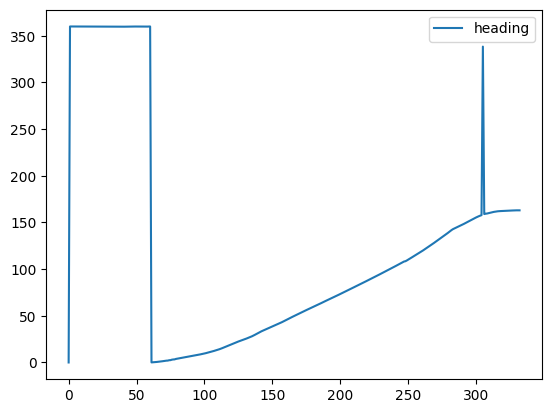

In [23]:
maneuvers[1][["heading"]].plot()

In [4]:
def continize_heading(df):
  df["rev_heading"] = df["heading"]

  for row_idx in range(1,len(df)):
    prev = df.iloc[row_idx-1]
    curr = df.iloc[row_idx]

    #from 10 to 350
    if curr["heading"] > 270 and prev["heading"] < 90:
      #print("Low-High", row_idx)
      df.loc[row_idx:, "rev_heading"] = df.loc[row_idx:, "rev_heading"] - 360
      #from 350 -> 10
    elif (prev["heading"]) > 270 and (curr["heading"]) < 90:
      #print("high-Low", row_idx)
      df.loc[row_idx:, "rev_heading"] = df.loc[row_idx:, "rev_heading"] + 360

  return df

<AxesSubplot: >

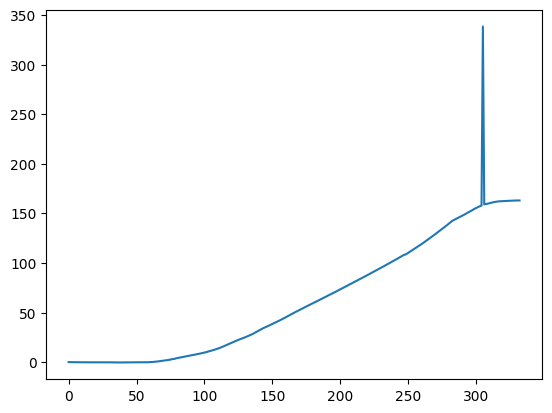

In [7]:
continize_heading(maneuvers[1].copy())["rev_heading"].plot()

In [5]:
def delta_heading(df, sampling_freq=0.1):
  continize_heading(df)
  df["partial_heading"] = df["rev_heading"].diff() / sampling_freq
  return df.loc[1:,:]

delta_heading(maneuvers[2].copy())

,idx,time,x,y,z,xVel,yVel,zVel,pitch,heading,roll,rev_heading,partial_heading
1,1,0.1,-1.351835,10.918864,0.0770,-15.790714,95.297967,0.1318,-0.6870,0.0082,-0.8999,0.0082,0.082
2,2,0.2,-3.081032,20.458653,0.1420,-15.789622,95.255494,0.1008,-0.7797,0.0190,-0.9142,0.0190,0.108
3,3,0.3,-4.812219,30.003029,0.2030,-15.789826,95.212240,0.0691,-0.8830,0.0334,-0.9276,0.0334,0.144
4,4,0.4,-6.572300,40.744805,0.2690,-15.791282,95.164083,0.0338,-0.9993,0.0512,-0.9415,0.0512,0.178
5,5,0.5,-8.296911,50.286584,0.3260,-15.793881,95.122080,0.0033,-1.1008,0.0677,-0.9541,0.0677,0.165
...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,345,34.5,-1219.962718,216.173136,-34.7680,67.205132,-32.391639,2.1390,-2.1655,110.7816,1.1592,-249.2184,-0.384
346,346,34.6,-1212.601556,212.722526,-34.5605,67.275844,-32.371213,2.0511,-0.8601,110.7520,1.0351,-249.2480,-0.296
347,347,34.7,-1205.240393,209.271915,-34.3315,67.346440,-32.369366,1.9425,0.1987,110.7426,0.8558,-249.2574,-0.094
348,348,34.8,-1197.658368,205.312144,-34.1195,67.410279,-32.383858,1.8100,0.8696,110.7556,0.6542,-249.2444,0.130


# Hypothesis Testing Preprocessing

Now, we have reducted the dimentionality from 11 features to 4 features. We will implement some helper functions that will assist in our hypothesis testing which will be conducted next.


In [6]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def obtain_sortie(length=120, probability_SLUF=0.4, transition="maneuver"):
  '''
  Generated synthetic sortie from exemplatory samples

          Parameters:
                  length (int): Minimium Length in seconds of sortie
                  probability_SLUF (int): Chance of SLUF being selected for each maneuver
                  transition (enum): Dictates how to handle transitionary period. Options: ["maneuver", "SLUF", "ignore","split"]
                                    "maneuver": Keeps the transition period as a individual Maneuver (-1 label)
                                    "SLUF"    : Makes entire transiton period SLUF (0 label)
                                    "ignore"  : Drops all transition periods
                                    "split"   : Splits the transition and adds to nearest maneuver (SLUF or Maneuver)

          Returns:
                  modified_sortie (pandas.DataFrame): Synthetic data frame of with columns ["speed","pitch","roll", "partial_heading", "maneuver"]
                  maneuver_ranges (pandas.DataFrame): Dataframe consisting of Manuever number and associated start and end times
  '''

  #Generate Sortie
  sortie_data, change_points, maneuver_choices = generate_sortie(length, maneuvers, p=probability_SLUF)

  #Add starting and ending change points
  change_points.append(sortie_data.iloc[-1]["time"])
  change_points.insert(0, 0)

  #Calculate maneuver ranges
  maneuver_ranges = pd.DataFrame([(maneuver_choices[i], change_points[i], change_points[i+1]) for i in range(len(maneuver_choices))],
                              columns=["maneuver","start_time","end_time"])

  if transition == "split":
    transient_times = maneuver_ranges[maneuver_ranges["maneuver"]==-1]
    split_times = transient_times["start_time"] + ((transient_times["end_time"] - transient_times["start_time"])/2)

    for idx in split_times.index:
      maneuver_ranges.loc[idx-1, "end_time"] = split_times[idx]
      maneuver_ranges.loc[idx+1, "start_time"] = split_times[idx]

    maneuver_ranges = maneuver_ranges[maneuver_ranges["maneuver"]!=-1]
  elif transition == "SLUF":
    maneuver_ranges.loc[maneuver_ranges["maneuver"]==-1, "maneuver"] = 0
  elif transition == "ignore":
    maneuver_ranges = maneuver_ranges[maneuver_ranges["maneuver"]!=-1]


  #Process generated sortie
  modified_sortie = calc_speed(sortie_data.copy())
  modified_sortie = delta_heading(modified_sortie)
  modified_sortie = pd.merge_asof(modified_sortie, maneuver_ranges, left_on='time', right_on="start_time")
  modified_sortie = modified_sortie[["speed","pitch","roll", "partial_heading", "maneuver"]]
  return modified_sortie, maneuver_ranges

def plot_roc(label, score, title=""):
  fpr, tpr, thresholds = roc_curve(label, score, pos_label=0)
  plt.plot(fpr,tpr)
  plt.title(title + f' auc:{round(auc(fpr, tpr),5)}')
  plt.plot([0, 1], [0, 1],'r--')
  plt.show()

def pred_VS_actual(ax, thresholds, tpr, fpr, sortie_data, true_ranges, title=None):
    category_colors = {
        0: 'blue', #sluf
        1: 'red', #maneuver
        -1: 'green' #transition
    }

    label_map = {
        'blue':'SLUF',
        'red':'Maneuver',
        'green':'Transient'
    }
    optimal_thresh = thresholds[np.argmax(tpr - fpr)]
    predictions = [0 if x >= optimal_thresh else 1 for x in sortie_data]

    actualRanges = true_ranges[['start_time', 'end_time']].values
    actualColors = [category_colors[i] if i in category_colors else category_colors[1] for i in true_ranges['maneuver'].values]

    # get ranges from predictions
    predictedRanges = []
    predictedColors = []
    start = 0
    curr = predictions[0]
    predictedColors.append(category_colors[curr])
    for i in range(1,len(predictions)):
        pred = predictions[i]
        if pred != curr:
            predictedRanges.append([start, i/10])
            curr = pred
            start = i/10
            predictedColors.append(category_colors[curr])
        if i == len(predictions) -1:
            predictedRanges.append([start, i/10])

    # plot
    for i in range(len(actualColors)):
        ax.hlines(y=25, xmin=actualRanges[i][0], xmax=actualRanges[i][1], colors=actualColors[i], linewidth=20)
    for i in range(len(predictedColors)):
        ax.hlines(y=15, xmin=predictedRanges[i][0], xmax=predictedRanges[i][1], colors=predictedColors[i], linewidth=20)

    for color in label_map: #create legend labels
        ax.plot([],[],color=color, label=label_map[color])
    ax.set_yticks([15, 25], labels=['Predicted','Actual'])
    ax.set_ylim(5, 35)
    if title != None:
        ax.set_title(title)
    else:
        ax.set_title("1D Visualization of Decision Region")
    ax.legend()

    return optimal_thresh

# Change Point Detection Implementation

Now that we have (synthetic) data and known change points, we can work on implementing Change Point Detection (CPD). The methods explored here will attempt to implement Online Change Point Detection. This is not nessisarily important in this step, but is critical for real world implementation. Online change point detection perform the analysis in real-time on a stream of data. This means the model can run in the background of the flight simulator. In contrast offline change point detection requires all the data to be seen at once. Although this is not an error now, this would mean pilots utilizing the simulator would not know the score of thier maneuvers until after they were finished flying.

## Fixed Sample Hypothesis Test

Fixed sample hypothesis testing involves having a known number of samples to form a hypothesis test. The result is then compared against a threshold. This is the first form of methods we will examine.

Portions of this code will use a difference in means. Due since we use one SLUF in our generator, we need a independant sample to compare against.

In [39]:
#This is purposefully different due to the data format differences between sample sorties and real sorties
col_names_std = ["idx", "time", "x", "y", "z", "xVel", "yVel", "zVel", "heading", "pitch", "roll"]
# SLUF_mean = clean_data(pd.read_csv("./SLUF_long.tsv", sep='\t', skiprows=[0], names=col_names_std))
SLUF_mean = maneuvers[0]

hyp_SLUF = calc_speed(SLUF_mean.copy())
hyp_SLUF = delta_heading(hyp_SLUF)

hyp_SLUF_cov = hyp_SLUF[["speed","pitch","roll", "partial_heading"]].cov()
hyp_SLUF_mu = hyp_SLUF[["speed","pitch","roll", "partial_heading"]].mean()
hyp_SLUF_std = hyp_SLUF[["speed","pitch","roll", "partial_heading"]].std()

### Energy Detector

The most niave approach to test for maneuver segements is a single-shot energy detector. This treats the problem as a signal-in-noise problem with a single observation. This is a standard first test since it assumes we have no information (model/parameters) about the data.

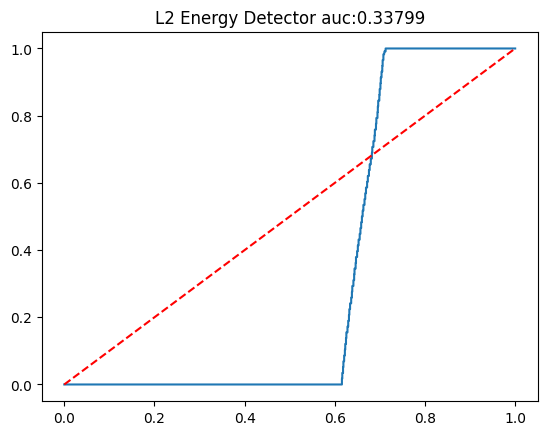

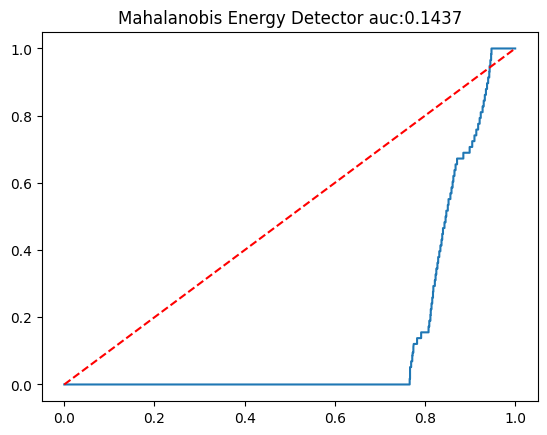

In [177]:
from scipy.spatial.distance import mahalanobis

#Obtain sample data
modified_sortie, true_ranges = obtain_sortie(transition="maneuver")

#Turn all Non-SLUF maneuvers to 1
modified_sortie.loc[modified_sortie["maneuver"]!=0, "maneuver"] = 1

#Energy Detector with L2 Norm
modified_sortie["L2_Energy"] = np.sqrt(np.square(modified_sortie.drop(['maneuver'], axis=1)).sum(axis=1))

#Energy Detector with Mahalanobis Distance
mu = modified_sortie.drop(['maneuver', "L2_Energy"], axis=1).mean()
cov = modified_sortie.drop(['maneuver', "L2_Energy"], axis=1).cov()
modified_sortie["Mah_Energy"] = modified_sortie.drop(['maneuver', "L2_Energy"], axis=1).apply(mahalanobis, axis=1, args=(mu, np.linalg.inv(cov)))

#Plot ROC Curve
plot_roc(modified_sortie["maneuver"], modified_sortie["L2_Energy"], title="L2 Energy Detector")
plot_roc(modified_sortie["maneuver"], modified_sortie["Mah_Energy"], title="Mahalanobis Energy Detector")

#### 1D Visulization of Decision Regions

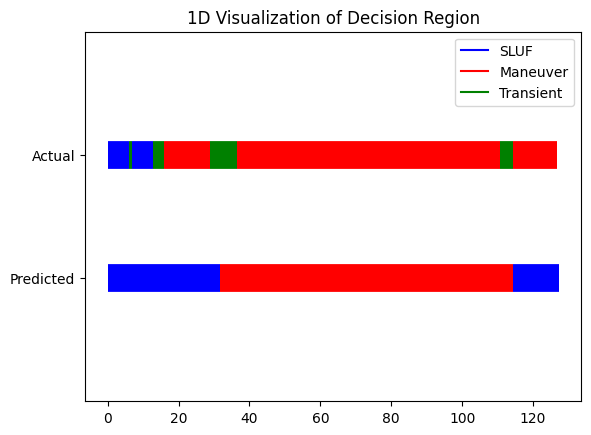

In [57]:
fpr, tpr, thresholds = roc_curve(modified_sortie["maneuver"], modified_sortie["L2_Energy"], pos_label=0)
fig, ax = plt.subplots()
pred_VS_actual(ax, thresholds,tpr,fpr,modified_sortie["L2_Energy"],true_ranges)
plt.show()

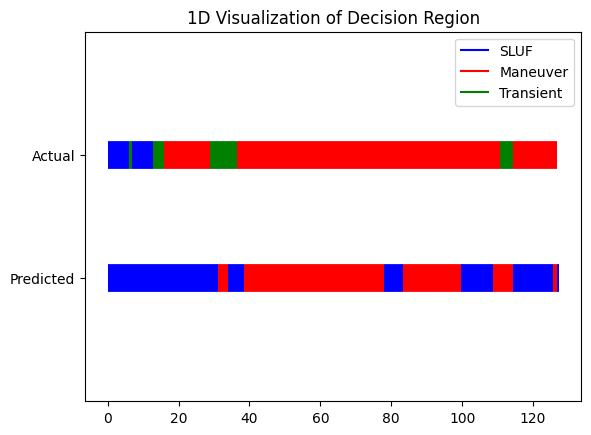

In [56]:
fpr, tpr, thresholds = roc_curve(modified_sortie["maneuver"], modified_sortie["Mah_Energy"], pos_label=0)
fig, ax = plt.subplots()
pred_VS_actual(ax, thresholds,tpr,fpr,modified_sortie["Mah_Energy"],true_ranges)
plt.show()

#### Monte-Carlo Threshold Estimation

In [58]:
from scipy.spatial.distance import mahalanobis
iters = 100

L2_AUC = []
Mal_AUC = []

for _ in range(iters):
  #Obtain sample data
  modified_sortie, _ = obtain_sortie(transition="maneuver")

  #Turn all Non-SLUF maneuvers to 1
  modified_sortie.loc[modified_sortie["maneuver"]!=0, "maneuver"] = 1

  #Energy Detector with L2 Norm
  modified_sortie["L2_Energy"] = np.sqrt(np.square(modified_sortie.drop(['maneuver'], axis=1)).sum(axis=1))

  #Energy Detector with Mahalanobis Distance
  mu = modified_sortie.drop(['maneuver', "L2_Energy"], axis=1).mean()
  cov = modified_sortie.drop(['maneuver', "L2_Energy"], axis=1).cov()
  modified_sortie["Mah_Energy"] = modified_sortie.drop(['maneuver', "L2_Energy"], axis=1).apply(mahalanobis, axis=1, args=(mu, np.linalg.inv(cov)))

  #Plot ROC Curve
  fpr, tpr, thresholds = roc_curve(modified_sortie["maneuver"], modified_sortie["L2_Energy"], pos_label=0)
  L2_AUC.append(max(auc(fpr, tpr), 1-auc(fpr, tpr)))

  fpr, tpr, thresholds = roc_curve(modified_sortie["maneuver"], modified_sortie["Mah_Energy"], pos_label=0)
  Mal_AUC.append(max(auc(fpr, tpr), 1-auc(fpr, tpr)))

print(f"Average L2 Energy AUC:{sum(L2_AUC)/iters}")
print(f"Average Mahalanobis Energy AUC: {sum(Mal_AUC)/iters}")

Average L2 Energy AUC:0.7696299472767594
Average Mahalanobis Energy AUC: 0.8154252534178619


### Energy Detector Analysis

Since our data is not stationary on the time domain, we must carefully craft our hypothesis to be time independant. This is important as single data points must not be dependant on the time of the maneuver. For example, if we niavely calculate $$\ln \frac{P(x|H_1)}{P(x|H_0)} = \ln \frac{P(x|μ_{\text{SLUF}}, Σ_{\text{SLUF}})}{P(x|μ_{\text{Maneuver}}, Σ_{\text{Manuever}})}=\ln P(x|μ_{\text{SLUF}}, Σ_{\text{SLUF}}) - P(x|μ_{\text{Maneuver}}, Σ_{\text{Manuever}}) = \mathcal{N}(\mathbf{0},I)$$

our data is still dependant on the time domain since $μ_{\text{Maneuver}}, Σ_{\text{Manuever}}$ are time dependant. Instead, will instead calculate the likelihood the data point is in SLUF.

We can instead view this problem as a signal in noise since $μ_{\text{SLUF}}, Σ_{\text{SLUF}}$ are time independant. This is the same as testing for a difference in means.

$$\ln \frac{P(x|H_1)}{P(x|H_0)} = \ln P(\bar x_{Window}|μ_{\text{SLUF}}, Σ_{\text{SLUF}})$$

Where $\bar x_{Window}$ is the average feature over 'window' time steps where 'window' $> 0$. When 'window' = 1, this is called single-shot detection since we are only viewing 1 datapoint. In contrast multipoint detection is implementing a 'moving average' window with a lookback of 'window' time steps. We will implement both of these methods below.

### Single-Shot Difference in Means

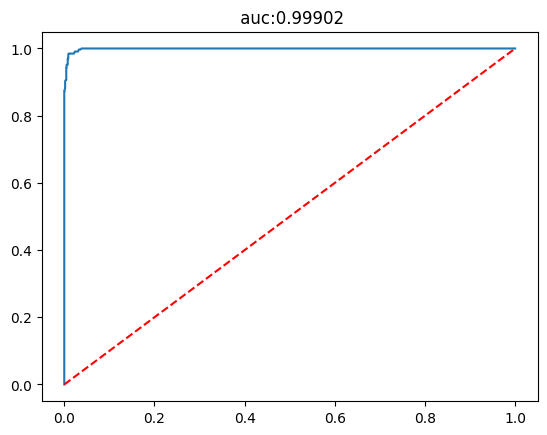

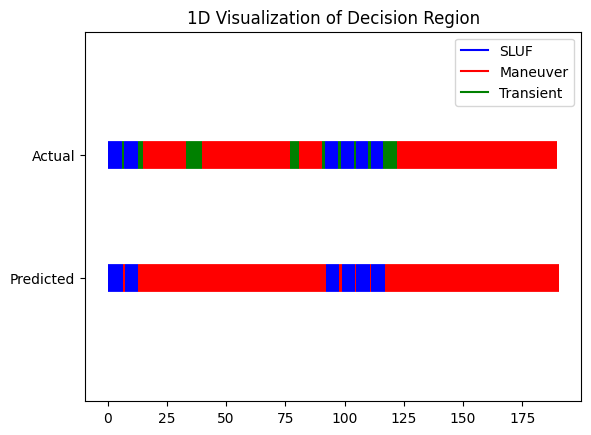

In [200]:
from scipy.stats import multivariate_normal
# SLUF_mean = maneuvers[0]
# hyp_SLUF = calc_speed(SLUF_mean.copy())
# hyp_SLUF = delta_heading(hyp_SLUF)

# hyp_SLUF_cov = hyp_SLUF[["speed","pitch","roll", "partial_heading"]].cov()
# hyp_SLUF_mu = hyp_SLUF[["speed","pitch","roll", "partial_heading"]].mean()
# hyp_SLUF_std = hyp_SLUF[["speed","pitch","roll", "partial_heading"]].std()

# Obtain sample data
original_sortie, true_ranges = obtain_sortie(transition="maneuver")

modified_sortie = original_sortie.copy()
#Turn all Non-SLUF maneuvers to 1
modified_sortie.loc[modified_sortie["maneuver"]!=0, "maneuver"] = 1

#Difference in Means hypothesis
modified_sortie["delta_mean"] = modified_sortie.drop(['maneuver'], axis=1).apply(multivariate_normal.pdf, axis=1, args=(hyp_SLUF_mu, hyp_SLUF_cov))

#Plot ROC Curve and pred vs actual
plot_roc(modified_sortie["maneuver"], modified_sortie["delta_mean"])

fpr, tpr, thresholds = roc_curve(modified_sortie["maneuver"], modified_sortie["delta_mean"], pos_label=0)

fig, ax = plt.subplots()
optimal_thresh = pred_VS_actual(ax, thresholds,tpr,fpr,modified_sortie["delta_mean"],true_ranges)
plt.show()

In [201]:
maneuver_means = {}
maneuver_covs = {}
for i, man in enumerate(maneuvers):

    hyp = calc_speed(man.copy())
    hyp = delta_heading(hyp)

    cov = hyp[["speed","pitch","roll", "partial_heading"]].cov()
    mu = hyp[["speed","pitch","roll", "partial_heading"]].mean()

    maneuver_means[maneuver_names[i]] = mu
    maneuver_covs[maneuver_names[i]] = cov


In [203]:
def pred_VS_actual_maneuver(ax, sortie_data, true_ranges, title=None):
    category_colors = {
        0: 'blue',              # SLUF
        1: 'red',               # 45SteepTurn
        2: 'darkorange',        # 60SteepTurn
        3: 'gold',              # AileronRoll
        4: 'limegreen',         # BarrelRoll
        5: 'deepskyblue',       # Cuban8
        6: 'cyan',              # ELP-FL
        7: 'indigo',            # ELP-PEL
        8: 'darkmagenta',       # Immelman
        9: 'darkorchid',        # IntentionalSpin
        10: 'saddlebrown',      # Lazy8
        11: 'dimgray',          # Loop
        12: 'springgreen',      # NoseHighRecovery
        13: 'darkred',          # NoseLowRecovery
        14: 'purple',           # SlowFlight
        15: 'greenyellow',      # SplitS
        16: 'mediumslateblue',  # UnusualAttitudeNoseLow
        17: 'darkcyan',         # VerticalSbravo
        -1: 'black'             # Transition
    }

    label_map = {
        'blue': 'SLUF',
        'red': '45SteepTurn',
        'darkorange': '60SteepTurn',
        'gold': 'AileronRoll',
        'limegreen': 'BarrelRoll',
        'deepskyblue': 'Cuban8',
        'cyan': 'ELP-FL',
        'indigo': 'ELP-PEL',
        'darkmagenta': 'Immelman',
        'darkorchid': 'IntentionalSpin',
        'saddlebrown': 'Lazy8',
        'dimgray': 'Loop',
        'springgreen': 'NoseHighRecovery',
        'darkred': 'NoseLowRecovery',
        'purple': 'SlowFlight',
        'greenyellow': 'SplitS',
        'mediumslateblue': 'UnusualAttitudeNoseLow',
        'darkcyan': 'VerticalSbravo',
        'black': 'Transition'
    }



    actualRanges = true_ranges[['start_time', 'end_time']].values
    actualColors = [category_colors[i] if i in category_colors else category_colors[1] for i in true_ranges['maneuver'].values]

    # get ranges from predictions
    predictedRanges = []
    predictedColors = []
    start = 0
    curr = sortie_data[0]
    predictedColors.append(category_colors[int(curr)])
    for i in range(1,len(sortie_data)):
        pred = sortie_data[i]
        if pred != curr:
            predictedRanges.append([start, i/10])
            curr = pred
            start = i/10
            predictedColors.append(category_colors[int(curr)])
        if i == len(sortie_data) -1:
            predictedRanges.append([start, i/10])

    # plot
    plotcolors = set()
    for i in range(len(actualColors)):
        ax.hlines(y=25, xmin=actualRanges[i][0], xmax=actualRanges[i][1], colors=actualColors[i], linewidth=20)
        plotcolors.add(actualColors[i])
    for i in range(len(predictedColors)):
        ax.hlines(y=15, xmin=predictedRanges[i][0], xmax=predictedRanges[i][1], colors=predictedColors[i], linewidth=20)
        plotcolors.add(predictedColors[i])

    for color in label_map: #create legend labels
        if color in plotcolors:
            ax.scatter([],[],color=color, label=label_map[color])


    ax.set_yticks([15, 25], labels=['Predicted','Actual'])
    ax.set_ylim(5, 35)
    if title != None:
        ax.set_title(title)
    else:
        ax.set_title("1D Visualization of Decision Region")
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=5)

C:\Users\fuzzi\AppData\Local\Temp\ipykernel_5692\73741409.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sortie['decision_stat'] = sortie.drop(['speed','pitch','roll','partial_heading','maneuver'],axis=1).max(axis="columns")


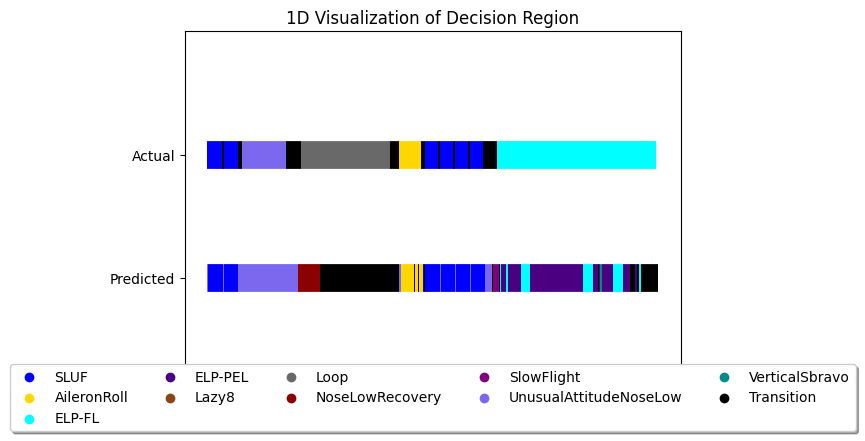

In [211]:
def id_maneuver(sortie, optimal_thresh):
    for i, man in enumerate(maneuver_names):
        sortie[f"{i}"] = sortie[['speed','pitch','roll','partial_heading']].apply(multivariate_normal.pdf, axis=1, args=(maneuver_means[man], maneuver_covs[man]))

    sortie['decision'] = sortie.drop(['speed','pitch','roll','partial_heading','maneuver'],axis=1).idxmax(axis="columns")
    sortie['decision_stat'] = sortie.drop(['speed','pitch','roll','partial_heading','maneuver'],axis=1).max(axis="columns")
    sortie.loc[sortie['decision_stat'] < optimal_thresh, 'decision'] = -1

    fig, ax = plt.subplots()
    pred_VS_actual_maneuver(ax,sortie["decision"],true_ranges)
    plt.show()

id_maneuver(original_sortie.copy(), 1e-7)

#### Monte-Carlo Threshold Estimation

In [ ]:
from scipy.stats import multivariate_normal

#calculate Cov and Mu from sample SLUF
hyp_SLUF = calc_speed(maneuvers[0].copy())
hyp_SLUF = delta_heading(hyp_SLUF)

hyp_SLUF_cov = hyp_SLUF[["speed","pitch","roll", "partial_heading"]].cov()
hyp_SLUF_mu = hyp_SLUF[["speed","pitch","roll", "partial_heading"]].mean()

iters = 100
diff_AUC = []
optimal_thresholds = []

for _ in range(iters):
  #Obtain sample data
  modified_sortie, _ = obtain_sortie(transition="maneuver")

  #Turn all Non-SLUF maneuvers to 1
  modified_sortie.loc[modified_sortie["maneuver"]!=0, "maneuver"] = 1

  #Difference in Means hypothesis
  modified_sortie["delta_mean"] = modified_sortie.drop(['maneuver'], axis=1).apply(multivariate_normal.pdf, axis=1, args=(hyp_SLUF_mu, hyp_SLUF_cov))

  #Plot ROC Curve
  fpr, tpr, thresholds = roc_curve(modified_sortie["maneuver"], modified_sortie["delta_mean"], pos_label=0)
  diff_AUC.append(auc(fpr, tpr))
  optimal_thresholds.append(thresholds[np.argmax(tpr - fpr)])

print(f"Average Difference in Means AUC: {sum(diff_AUC)/iters}")
print(f"Average Optimal Threshold:{sum(optimal_thresholds)/iters}")

Average Difference in Means AUC: 0.9993073648734279
Average Optimal Threshold:0.00019130922262190826


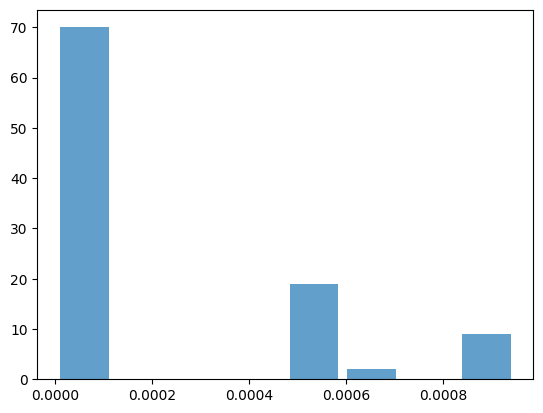

In [ ]:
plt.hist(optimal_thresholds, bins='auto', alpha=0.7, rwidth=0.85)
plt.show()

In [65]:
modified_sortie

,speed,pitch,roll,partial_heading,maneuver,delta_mean
10,103.616949,-1.57964,-4.94005,-1.1540,0.0,3.470649e-03
11,103.724353,-1.18094,-4.97572,-1.0021,0.0,4.193038e-03
12,103.833770,-0.90623,-4.98709,-0.8140,0.0,4.695380e-03
13,103.945889,-0.74643,-4.97316,-0.5954,0.0,4.800829e-03
14,104.061054,-0.69975,-4.93751,-0.3574,0.0,4.839909e-03
...,...,...,...,...,...,...
1297,112.421081,5.97698,-1.63440,-1.2282,1.0,1.058496e-08
1298,112.532615,4.15481,-1.74888,0.3118,1.0,1.058496e-08
1299,112.649335,2.60881,-1.85215,1.7362,1.0,1.058496e-08
1300,112.768317,1.40101,-1.93651,2.9147,1.0,1.058496e-08


### Multi-sample Difference in Means (Rolling Window)

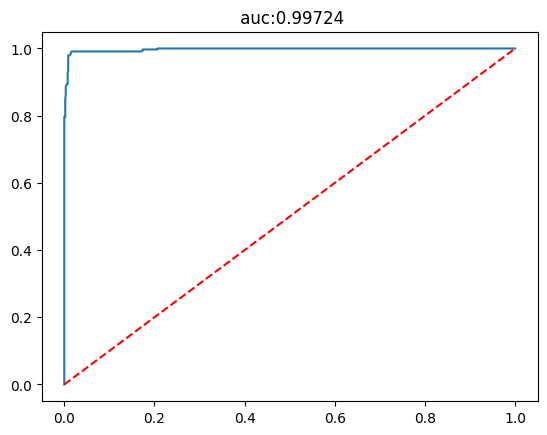

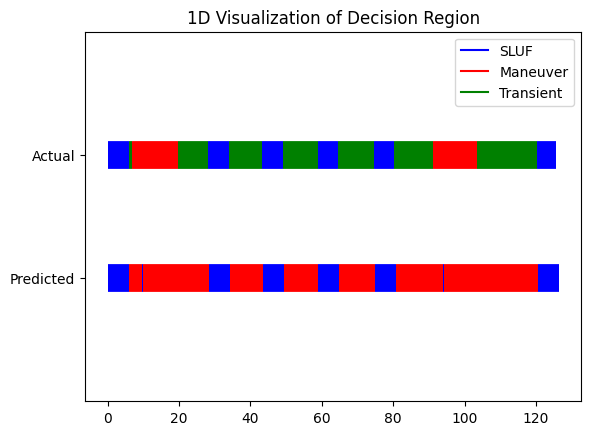

In [117]:
plot_roc(modified_sortie["maneuver"], modified_sortie["delta_mean"])

fpr, tpr, thresholds = roc_curve(modified_sortie["maneuver"], modified_sortie["delta_mean"], pos_label=0)

fig, ax = plt.subplots()
pred_VS_actual(ax, thresholds,tpr,fpr,modified_sortie["delta_mean"],true_ranges)
plt.show()

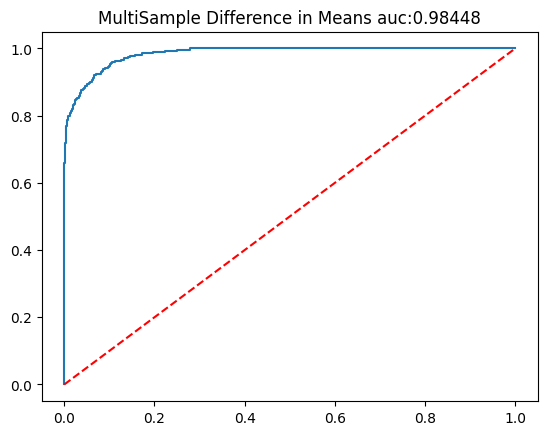

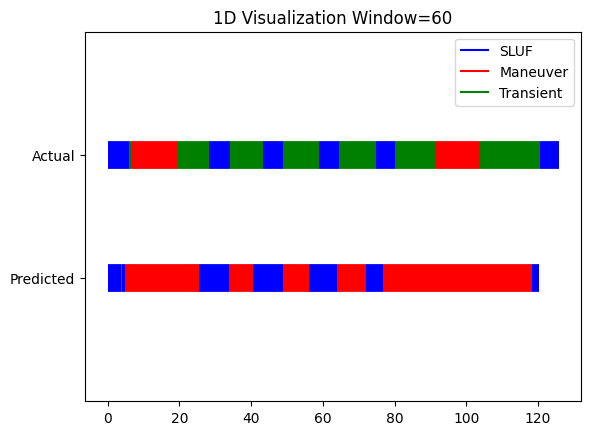

In [125]:
from scipy.stats import multivariate_normal

#number of observations to ignore (sample_freq = 10Hz)
window_size = 60
sample_freq = 10

#Obtain sample data
# original_sortie, true_ranges = obtain_sortie(120, transition="maneuver")

#true_ranges["end_time"] = true_ranges["end_time"]-(window_size/sample_freq)
true_ranges2 = pd.DataFrame()
true_ranges2['maneuver'] = true_ranges['maneuver']
true_ranges2[["end_time","start_time"]] = true_ranges[["end_time","start_time"]]
true_ranges2.loc[true_ranges2["start_time"] < 0, "start_time"] = 0
modified_sortie2 = modified_sortie.copy()
modified_sortie2.drop(['delta_mean'], axis=1,inplace=True)

#Turn all Non-SLUF maneuvers to 1
modified_sortie2.loc[modified_sortie2["maneuver"]!=0, "maneuver"] = 1

#implement Rolling Window
modified_sortie2 = modified_sortie2.rolling(window_size).mean()

#remove NA values
modified_sortie2 = modified_sortie2.iloc[window_size:]

#Discritize maneuver
modified_sortie2.loc[modified_sortie2["maneuver"]>=0.5, "maneuver"] = 1
modified_sortie2.loc[modified_sortie2["maneuver"]<0.5, "maneuver"] = 0

#Difference in Means hypothesis
modified_sortie2["delta_mean"] = modified_sortie2.drop(['maneuver'], axis=1).apply(multivariate_normal.pdf, axis=1, args=(hyp_SLUF_mu, hyp_SLUF_cov))

#Plot ROC Curve
plot_roc(modified_sortie2["maneuver"], modified_sortie2["delta_mean"], title="MultiSample Difference in Means")

fpr, tpr, thresholds = roc_curve(modified_sortie2["maneuver"], modified_sortie2["delta_mean"], pos_label=0)

fig, ax = plt.subplots()
pred_VS_actual(ax, thresholds,tpr,fpr,modified_sortie2["delta_mean"],true_ranges2, title=f"1D Visualization Window={window_size}")
plt.show()

In [106]:
modified_sortie2

,speed,pitch,roll,partial_heading,maneuver,delta_mean
60,107.530979,-2.067106,-3.752839,-0.478811,0.0,5.018293e-02
61,107.663979,-2.017676,-3.710532,-0.451343,0.0,4.972023e-02
62,107.778233,-1.996500,-3.670640,-0.421230,0.0,4.924474e-02
63,107.870183,-2.003653,-3.634230,-0.389108,0.0,4.883551e-02
64,107.938053,-2.039523,-3.602454,-0.356279,0.0,4.842137e-02
...,...,...,...,...,...,...
1208,114.065415,-17.734675,-12.032863,-2.505300,1.0,0.000000e+00
1209,114.264842,-17.263810,-11.777303,-2.454983,1.0,0.000000e+00
1210,114.459227,-16.793457,-11.520920,-2.400200,1.0,0.000000e+00
1211,114.648830,-16.324195,-11.263693,-2.346500,1.0,0.000000e+00


#### Monte-Carlo Threshold Estimation

In [127]:
from scipy.stats import multivariate_normal

#calculate Cov and Mu from sample SLUF
hyp_SLUF = calc_speed(maneuvers[0].copy())
hyp_SLUF = delta_heading(hyp_SLUF)

hyp_SLUF_cov = hyp_SLUF[["speed","pitch","roll", "partial_heading"]].cov()
hyp_SLUF_mu = hyp_SLUF[["speed","pitch","roll", "partial_heading"]].mean()

window_size = 100

iters = 100
diff_AUC = []
optimal_thresholds = []

for _ in range(iters):
  #Obtain sample data
  modified_sortie, _ = obtain_sortie(transition="maneuver")

  #Turn all Non-SLUF maneuvers to 1
  modified_sortie.loc[modified_sortie["maneuver"]!=0, "maneuver"] = 1

  #implement Rolling Window
  modified_sortie = modified_sortie.rolling(window_size).mean()

  #remove NA values
  modified_sortie = modified_sortie.iloc[window_size:]

  #Discritize maneuver
  modified_sortie.loc[modified_sortie["maneuver"]>=0.5, "maneuver"] = 1
  modified_sortie.loc[modified_sortie["maneuver"]<0.5, "maneuver"] = 0

  #Difference in Means hypothesis
  modified_sortie["delta_mean"] = modified_sortie.drop(['maneuver'], axis=1).apply(multivariate_normal.pdf, axis=1, args=(hyp_SLUF_mu, hyp_SLUF_cov))

  #Plot ROC Curve
  fpr, tpr, thresholds = roc_curve(modified_sortie["maneuver"], modified_sortie["delta_mean"], pos_label=0)
  diff_AUC.append(auc(fpr, tpr))
  optimal_thresholds.append(thresholds[np.argmax(tpr - fpr)])

print(f"Average Difference in Means AUC: {sum(diff_AUC)/iters}")
print(f"Average Optimal Threshold:{sum(optimal_thresholds)/iters}")

Average Difference in Means AUC: 0.9824299466625647
Average Optimal Threshold:0.0006280211149990517


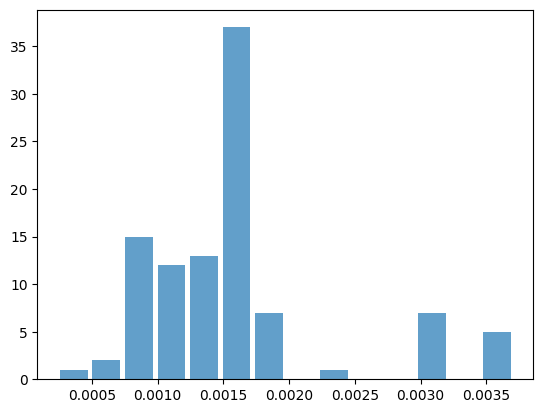

In [ ]:
plt.hist(optimal_thresholds, bins='auto', alpha=0.7, rwidth=0.85)
plt.show()

## Sequential Hypothesis Testing

In contrast to fixed sample hypothesis testing, Sequential hypothesis has a unknown number of samples. We will examine these methods next

### SPRT

The first sequential algorithm we will explore is SPRT which stands for Sequential Probability Ratio Test. More information can be obtained [here](https://en.wikipedia.org/wiki/Sequential_probability_ratio_test).

#### **Problem Setup**

Suppose we have a stream of data, $\{ x_1, \dots,  x_n \}$, where $n$ is unknown (likely infinite). The datapoints $\{ x_1, \dots,  x_{τ} \}$ sampled from $P(H_0)$ from time $[0,τ]$ before the sampling distrubution changes for data points $\{ x_{τ + 1}, \dots,  x_n \}$ to $P(H_1)$. We wish to identify $τ$.

#### **SPRT Approach**
One method to identify tau is to perform a hypothesis test at each datapoint. That is

$$λ(x_i) = \ln \frac{P(x_i|H_1)}{P(x_i|H_0)}$$

If $λ(x_i) > 0$, we predict $H_1$ if $λ(x_i) < 0$, we predict $H_0$. Since the larger the value, the more certain we are of our choise, we can then keep track of the running total of our likelihoods, $λ(x_i)$, with the update rule:

$$S_0 = 0$$
$$S_{n} = S_{n-1} + λ(x_n)$$

Then, we have threshold values, $a$ and $b$. These threshold values determine our prediction. If $a < S_n < b$, then we perform another update on $S_n$. Otherwise we use the decision rule below.

$$S_{n} > b: H1$$
$$S_{n} < a: H0$$

$a$ and $b$ are generally calculated with the rules:
$$a \approx \ln \frac \beta {1-\alpha}$$
$$b \approx \ln \frac {1-\beta} \alpha$$

Where $\alpha$ and $\beta$ are type I and type II errors respectively.

aya
accuracy 0.40086206896551735


C:\Users\fuzzi\AppData\Local\Temp\ipykernel_4812\3431233581.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['amt'] = temp['end_time']-temp['start_time']
C:\Users\fuzzi\AppData\Local\Temp\ipykernel_4812\3431233581.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['amt'] = temp['end_time']-temp['start_time']


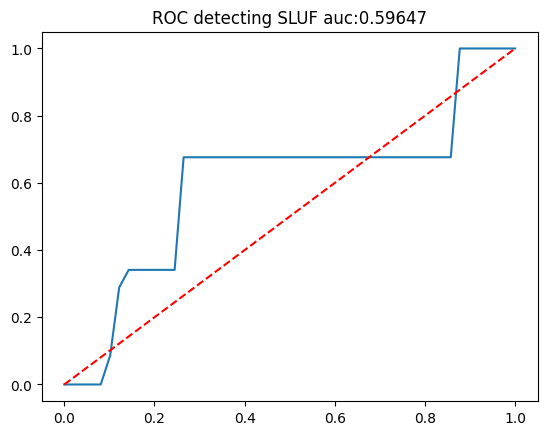

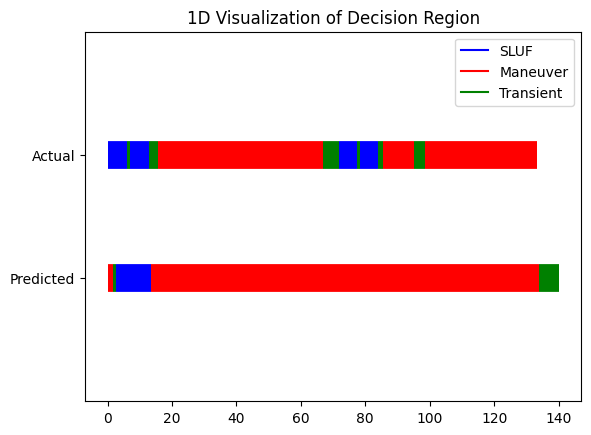

In [116]:
## Code implementing SPRT

# sequential hypothesis test. keep adding lambdas to S_n. if S_n<A NonSLUF, A<S_n<B transition, B<S_n SLUF

from sklearn import metrics 
from scipy.stats import multivariate_normal

SLUF_mean = maneuvers[0]
hyp_SLUF = calc_speed(SLUF_mean.copy())
hyp_SLUF = delta_heading(hyp_SLUF)

hyp_SLUF_cov = hyp_SLUF[["speed","pitch","roll", "partial_heading"]].cov()
hyp_SLUF_mu = hyp_SLUF[["speed","pitch","roll", "partial_heading"]].mean()
hyp_SLUF_std = hyp_SLUF[["speed","pitch","roll", "partial_heading"]].std()

log_sluf_mu_2 = np.log(multivariate_normal.pdf(hyp_SLUF_mu, hyp_SLUF_mu, hyp_SLUF_cov)) * 2


def plot_sprt(ax, true_ranges, estimated_ranges, title="1D Visualization of Decision Region"):
    category_colors = {
        0: 'blue', #sluf
        1: 'red', #maneuver
        -1: 'green' #transition
    }

    label_map = {
        'blue':'SLUF',
        'red':'Maneuver',
        'green':'Transient'
    }
    actualRanges = true_ranges[['start_time', 'end_time']].values
    actualColors = [category_colors[i] if i in category_colors else category_colors[1] for i in true_ranges['maneuver'].values]

    predictedRanges = estimated_ranges[['start_time', 'end_time']].values
    predictedColors = [category_colors[i] if i in category_colors else category_colors[1] for i in estimated_ranges['maneuver'].values]

    for i in range(len(actualColors)):
        ax.hlines(y=25, xmin=actualRanges[i][0], xmax=actualRanges[i][1], colors=actualColors[i], linewidth=20)
    for i in range(len(predictedColors)):
        ax.hlines(y=15, xmin=predictedRanges[i][0], xmax=predictedRanges[i][1], colors=predictedColors[i], linewidth=20)

    for color in label_map: #create legend labels
        ax.plot([],[],color=color, label=label_map[color])
    ax.set_yticks([15, 25], labels=['Predicted','Actual'])
    ax.set_ylim(5, 35)
    ax.set_title(title)
    ax.legend()

def plotSPRT_ROC(decision_stats):
    decision_stats = decision_stats[np.argsort(decision_stats[:, 0])]
    fprs = 1-np.linspace(0,1)
    totalSluf = decision_stats[decision_stats[:,1]==0].shape[0]
    totalNonSluf = decision_stats[decision_stats[:,1]>=1].shape[0]
    fpr = []
    tpr = []
    numNonSluf = totalNonSluf
    numSluf = totalSluf

    idx = 0
    thresholds = []

    for i in decision_stats:
        if i[1] == 0:
            numSluf -= 1
        elif i[1] == -1:
            continue
        else:
            numNonSluf -= 1
        while numNonSluf/totalNonSluf < fprs[idx]:
            tpr.append(numSluf/totalSluf)
            fpr.append(numNonSluf/totalNonSluf)
            thresholds.append(i[0])
            idx += 1
            if idx > decision_stats.shape[0]:
                break
    optimal_thresh = thresholds[np.argmax(np.array(tpr)-np.array(fpr))]

    fpr = [1] + fpr + [0]
    tpr = [1] + tpr + [0]

    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr,tpr)
    plt.title(f'ROC detecting SLUF auc:{round(auc,5)}')
    plt.plot([0, 1], [0, 1],'r--')
    plt.show()
    
    return optimal_thresh

def triggerChange(df, start, end, maneuver):
    newrow = pd.DataFrame()
    newrow['start_time'] = [start / 10]
    newrow['end_time'] = [end / 10]
    newrow['maneuver'] = [maneuver]
    return pd.concat([df,newrow],axis=0)


def compareRanges(truerange, testrange):
    hits = 0
    idx1 = 0
    idx2 = 0

    temp = truerange[truerange['maneuver'] == 0]
    temp['amt'] = temp['end_time']-temp['start_time']
    totaltime = temp['amt'].sum()

    temp = testrange[testrange['maneuver'] == 0]
    temp['amt'] = temp['end_time']-temp['start_time']
    falsepos = temp['amt'].sum()

    while idx1 < truerange.shape[0] and idx2 < testrange.shape[0]:
        maneuver1, start1, end1 = truerange.iloc[idx1].values
        start2, end2, maneuver2 = testrange.iloc[idx2].values

        if maneuver1 == 0 and maneuver2 == 0:
            hits += min(end1,end2) - max(start1,start2)


        if end2 == end1:
            idx1 += 1
            idx2 += 1
        elif end2 > end1:
            idx1 += 1
        else:
            idx2 += 1
    tpr = hits / totaltime
    fpr = (falsepos-hits) / totaltime

    return tpr, fpr

def testThreshold(modified_sortie, decision_stats, thresh):
    predicted_ranges = pd.DataFrame()
    curr = -1
    start = 0
    for i in range(len(modified_sortie)):
        s = decision_stats[i,0]
        if s >= thresh:
            if curr != 0: #change
                predicted_ranges = triggerChange(predicted_ranges, start, i, curr)
                curr = 0
                start = i
        elif s <= -thresh:
            if curr != 1: #change
                predicted_ranges = triggerChange(predicted_ranges, start, i, curr)
                curr = 1
                start = i
        else:
            if curr != -1:
                predicted_ranges = triggerChange(predicted_ranges, start, i, curr)
                curr = -1
                start = i
    predicted_ranges = triggerChange(predicted_ranges, start, i, curr)
    return predicted_ranges

def sprt(sortie, true_ranges, a=None, b=None):

    # calc log likelihood
    epsilon = 1e-50
    modified_sortie["likelihood"] = sortie.drop(['maneuver'], axis=1).apply(multivariate_normal.pdf, axis=1, args=(hyp_SLUF_mu, hyp_SLUF_cov))
    modified_sortie['llikeli'] = np.log(modified_sortie['likelihood'].clip(lower=epsilon))

    
    S_n = 0
    decision_stats = np.ndarray((modified_sortie.shape[0],2))
    for i in range(len(modified_sortie)):
        S_n += modified_sortie.iloc[i]['llikeli'] - log_sluf_mu_2
        # S_n += modified_sortie.iloc[i]['llikeli']
        decision_stats[i,0] = S_n
        decision_stats[i,1] = modified_sortie.iloc[i]['maneuver']

    if a == None or b == None:
        type1ErrorRate = 0.025 #PFA
        type2ErrorRate = 0.025 #P miss
        a = np.log(type2ErrorRate/(1-type1ErrorRate))
        b = np.log((1-type2ErrorRate)/(type1ErrorRate))

 
    predicted_ranges = testThreshold(modified_sortie, decision_stats, b)
    accuracy, _ = compareRanges(true_ranges, predicted_ranges)
    print("accuracy",accuracy)
    plotSPRT_ROC(decision_stats)

    
    fig, ax = plt.subplots()
    plot_sprt(ax, true_ranges, predicted_ranges)
    plt.show()

# modified_sortie, true_ranges = obtain_sortie(transition="maneuver")
sprt(original_sortie, true_ranges, a=-10.0,b=10.0)

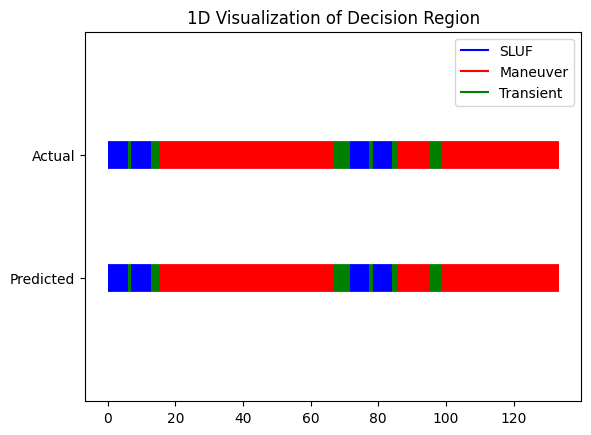

In [95]:
original_sortie, true_ranges = obtain_sortie(transition="maneuver")
fig, ax = plt.subplots()
plot_sprt(ax, true_ranges, true_ranges)
plt.show()

C:\Users\fuzzi\AppData\Local\Temp\ipykernel_4812\2522853089.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['amt'] = temp['end_time']-temp['start_time']
C:\Users\fuzzi\AppData\Local\Temp\ipykernel_4812\2522853089.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['amt'] = temp['end_time']-temp['start_time']
C:\Users\fuzzi\AppData\Local\Temp\ipykernel_4812\2522853089.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

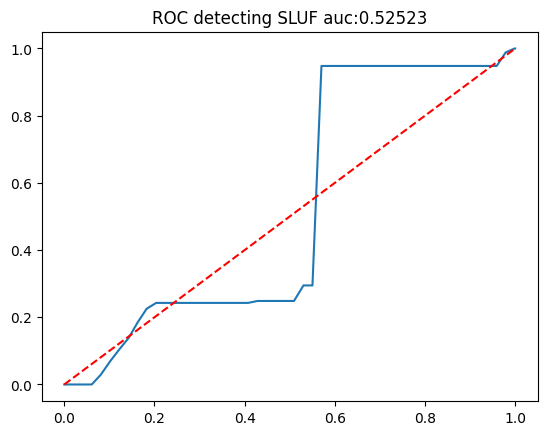

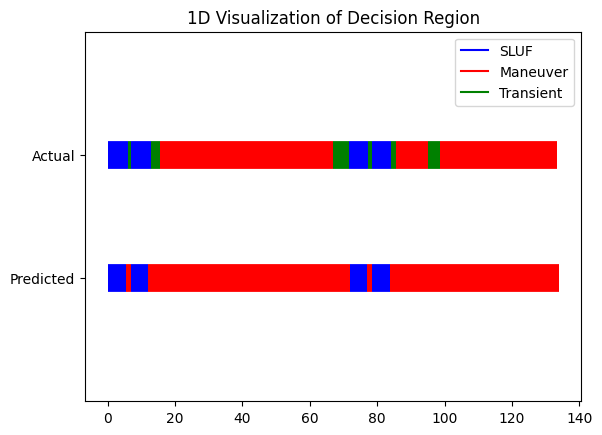

In [112]:

def asdf(modified_sortie, thresh):
    predicted_ranges = pd.DataFrame()
    decision_stats = np.ndarray((modified_sortie.shape[0],2))
        
    start = 0
    s = 0
    for i in range(len(modified_sortie)):
        s += modified_sortie.iloc[i]['llikeli'] - log_sluf_mu_2
        if s >= thresh:
            predicted_ranges = triggerChange(predicted_ranges, start, i, 0)
            s = 0
            start = i
            
        elif s <= -thresh:
            predicted_ranges = triggerChange(predicted_ranges, start, i, 1)
            s = 0
            start = i
        decision_stats[i,0] = s
        decision_stats[i,1] = modified_sortie.iloc[i]['maneuver']
        
    return predicted_ranges, decision_stats

def sprt2(sortie, true_ranges):

    # calc log likelihood
    epsilon = 1e-50
    modified_sortie["likelihood"] = sortie.drop(['maneuver'], axis=1).apply(multivariate_normal.pdf, axis=1, args=(hyp_SLUF_mu, hyp_SLUF_cov))
    modified_sortie['llikeli'] = np.log(modified_sortie['likelihood'].clip(lower=epsilon))    

    thresholds = np.linspace(0, 100, num=11)
    results = {}
    for thresh in thresholds:
        predicted_ranges, decision_stats = asdf(modified_sortie, thresh)
        tpr, fpr = compareRanges(true_ranges, predicted_ranges)
        results[thresh] = tpr-fpr
 

    optimal_thresh = max(results.keys(), key=lambda x: results[x])
    predicted_ranges, decision_stats = asdf(modified_sortie, optimal_thresh)
    plotSPRT_ROC(decision_stats)
    fig, ax = plt.subplots()
    plot_sprt(ax, true_ranges, predicted_ranges, title=f"1D Visualization of Decision Region")
    plt.show()
    return results

results = sprt2(original_sortie, true_ranges)

In [113]:
results

{0.0: 0.8793103448275857,
 10.0: 0.8879310344827589,
 20.0: 0.8577586206896546,
 30.0: 0.8706896551724134,
 40.0: 0.797413793103448,
 50.0: 0.5905172413793104,
 60.0: 0.42672413793103464,
 70.0: 0.8017241379310339,
 80.0: 0.7758620689655169,
 90.0: 0.4482758620689655,
 100.0: 0.4008620689655172}

# CUSUM

In [ ]:
import pandas as pd
import numpy as np

def cusum(series, target, threshold):
    S = 0
    cum_sum = [0]
    change_points = []
    for i, x in enumerate(series):
        deviation = x - target
        S = max(0, S + deviation) if deviation > 0 else min(0, S + deviation)
        cum_sum.append(S)
        if abs(S) > threshold:
            change_points.append(i)
            S = 0  # Reset after change detected
    return change_points, cum_sum

#Obtain sample data
modified_sortie, true_ranges = obtain_sortie(transition="maneuver")

#Turn all Non-SLUF maneuvers to 1
modified_sortie.loc[modified_sortie["maneuver"]!=0, "maneuver"] = 1

# Applying CUSUM
results = {}
cumulative_sums = {}
for param in ['speed', 'pitch', 'roll', 'partial_heading']:
    results[param], cumulative_sums[param] = cusum(modified_sortie[param], hyp_SLUF_mu[param], hyp_SLUF_std[param]*30)

In [ ]:
modified_sortie

,speed,pitch,roll,partial_heading,maneuver
0,103.045807,-5.7320,-4.3898,-1.086,0
1,103.146513,-4.7983,-4.4412,-1.333,0
2,103.247224,-3.7060,-4.6415,-1.477,0
3,103.349550,-2.7058,-4.8574,-1.626,0
4,103.454068,-1.7202,-5.0413,-1.740,0
...,...,...,...,...,...
1254,74.634599,-2.1655,1.1592,-0.384,1
1255,74.686957,-0.8601,1.0351,-0.296,1
1256,74.746853,0.1987,0.8558,-0.094,1
1257,74.807327,0.8696,0.6542,0.130,1


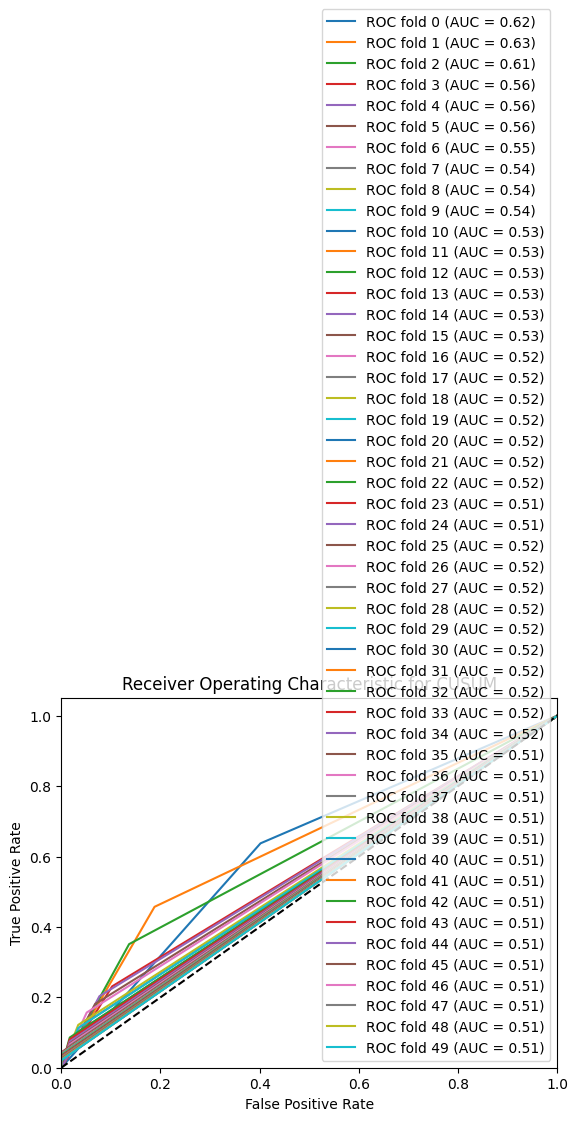

In [ ]:
thresholds = np.linspace(modified_sortie['speed'].std() / 2, modified_sortie['speed'].std() * 30, 50)
tprs = []
fprs = []
auc_values = []

def cusum_classify(series, target, thresholds):
  labels = np.zeros(len(series))
  for threshold in thresholds:
      S = 0
      for i, x in enumerate(series):
          deviation = x - target
          S = max(0, S + deviation) if deviation > 0 else min(0, S + deviation)
          if abs(S) > threshold:
              labels[i] = 1
              S = 0  # Reset after change detected
  return labels

# Evaluate performance for each threshold
for threshold in thresholds:
    predicted_labels = cusum_classify(modified_sortie['speed'], modified_sortie['speed'].mean(), [threshold])
    fpr, tpr, _ = roc_curve(modified_sortie['maneuver'], predicted_labels)
    roc_auc = auc(fpr, tpr)
    tprs.append(tpr)
    fprs.append(fpr)
    auc_values.append(roc_auc)

# Plot ROC Curve
plt.figure()
for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
    plt.plot(fpr, tpr, label='ROC fold %d (AUC = %0.2f)' % (i, auc_values[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for CUSUM')
plt.legend(loc="lower right")
plt.show()

In [ ]:
results

{'speed': [62,
  156,
  343,
  365,
  519,
  533,
  544,
  553,
  561,
  569,
  576,
  583,
  591,
  599,
  608,
  619,
  658,
  667,
  674,
  681,
  688,
  694,
  701,
  708,
  715,
  722,
  729,
  736,
  742,
  748,
  754,
  760,
  766,
  772,
  778,
  784,
  791,
  798,
  806,
  816,
  829,
  891,
  909,
  925,
  940,
  955,
  970,
  986,
  1004,
  1033,
  1116,
  1140,
  1154,
  1165,
  1174,
  1182,
  1189,
  1195,
  1201,
  1207,
  1212,
  1217,
  1222,
  1227,
  1232,
  1237,
  1242,
  1247,
  1252,
  1257],
 'pitch': [83,
  116,
  130,
  133,
  135,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  158,
  159,
  160,
  161,
  162,
  163,
  164,
  165,
  166,
  167,
  168,
  169,
  170,
  171,
  172,
  173,
  174,
  175,
  177,
  179,
  181,
  186,
  191,
  209,
  247,
  258,
  268,
  278,
  388,
  403,
  414,
  423,
  431,
  438,
  445,
  452,
  494,
  541,
  552,
  566,
  569,
  

In [ ]:
print("Change points detected:")
for param, indices in results.items():
    print(f"{param}: {indices}")

# Optional: Plot cumulative sums to visualize changes
import matplotlib.pyplot as plt

for param, cum_sum in cumulative_sums.items():
    plt.figure()
    plt.plot(cum_sum, label='Cumulative Sum')
    plt.title(f"CUSUM for {param}")
    plt.legend()
    plt.show()

# SPRT Energy Detector

In [ ]:
from scipy.spatial.distance import mahalanobis

#Use Energy Detector with Mahalanobis Distance
mu = modified_sortie.drop(['maneuver'], axis=1).mean()
cov = modified_sortie.drop(['maneuver'], axis=1).cov()
modified_sortie["Mah_Energy"] = modified_sortie.drop(['maneuver'], axis=1).apply(mahalanobis, axis=1, args=(mu, np.linalg.inv(cov)))

In [ ]:
from scipy.stats import multivariate_normal
from scipy.spatial.distance import mahalanobis

#Use Energy Detector with Mahalanobis Distance
mu = modified_sortie.drop(['maneuver'], axis=1).mean()
cov = modified_sortie.drop(['maneuver'], axis=1).cov()
modified_sortie["Mah_Energy"] = modified_sortie.drop(['maneuver'], axis=1).apply(mahalanobis, axis=1, args=(mu, np.linalg.inv(cov)))

#Predefined stopping points
type1ErrorRate = 0.025 #PFA
type2ErrorRate = 0.025 #P miss
a = np.log(type2ErrorRate/(1-type1ErrorRate))
b = np.log((1-type2ErrorRate)/(type1ErrorRate))

#Obtain sample data
modified_sortie, true_ranges = obtain_sortie(transition="maneuver")

#Turn all Non-SLUF maneuvers to 1
modified_sortie.loc[modified_sortie["maneuver"]!=0, "maneuver"] = 1

#Calculate log likelihood
epsilon = 1e-50
modified_sortie["likelihood"] = modified_sortie.drop(['maneuver'], axis=1).apply(multivariate_normal.pdf, axis=1, args=(hyp_SLUF_mu, hyp_SLUF_cov))
modified_sortie['llikeli'] = np.log(modified_sortie['likelihood'].clip(lower=epsilon))


modified_sortie["pred_maneuver"] = np.nan
modified_sortie["S_n"] = np.nan


#Use the update rule S_n = S_{n-1} + likelihood(S_n)
S_n = 0
for i in modified_sortie.index:
    S_n += modified_sortie.at[i, 'llikeli']  # Assuming 'llikeli' is log likelihood ratio
    if S_n >= b:
        modified_sortie.at[i, 'pred_maneuver'] = 1
        S_n = b  # Consider not resetting to 0 to maintain evidence accumulation
    elif S_n <= a:
        modified_sortie.at[i, 'pred_maneuver'] = 0
        S_n = a  # Consider not resetting to 0
    else:
        modified_sortie.at[i, 'pred_maneuver'] = np.nan  # for undecided cases
    modified_sortie.at[i, 'S_n'] = S_n


In [ ]:
prev_hypothesis = 0
S_n = 0
for i in range(len(modified_sortie)):
  S_n += modified_sortie["likelihood"][i]
  if S_n > b:
    prev_hypothesis = 1
    S_n = b
  if S_n < a:
    prev_hypothesis = 0
    S_n = a
  modified_sortie.loc[i, "pred_maneuver"] = prev_hypothesis
  modified_sortie.loc[i, "S_n"] = S_n

#modified_sortie.loc[modified_sortie["likelihood"] < epsilon, "llikeli"] = 0
#modified_sortie.loc[modified_sortie["likelihood"] >= epsilon, "llikeli"] = np.log(modified_sortie.loc[modified_sortie["likelihood"] >= epsilon, "likelihood"])

#any single data point that is above the threshold is predetermined.
#modified_sortie.loc[modified_sortie["llikeli"] <= a, "pred_maneuver"] = 0
#modified_sortie.loc[modified_sortie["llikeli"] >= b, "pred_maneuver"] = 1


-3.6635616461296463

In [ ]:
sum(modified_sortie["pred_maneuver"])
modified_sortie

,speed,pitch,roll,partial_heading,maneuver,likelihood,llikeli,pred_maneuver,S_n
0,103.045807,-5.7320,-4.3898,-1.086,0,1.119116e-10,-22.913312,0.0,-1.098612
1,103.146513,-4.7983,-4.4412,-1.333,0,2.729706e-13,-28.929412,0.0,-1.098612
2,103.247224,-3.7060,-4.6415,-1.477,0,3.951229e-15,-33.164750,0.0,-1.098612
3,103.349550,-2.7058,-4.8574,-1.626,0,1.195439e-17,-38.965433,0.0,-1.098612
4,103.454068,-1.7202,-5.0413,-1.740,0,5.355861e-20,-44.373510,0.0,-1.098612
...,...,...,...,...,...,...,...,...,...
1429,107.822705,-3.2744,-1.3414,-0.963,1,1.578949e-08,-17.963921,0.0,-1.098612
1430,107.857633,-2.8807,-1.2454,-1.010,1,3.707427e-09,-19.412928,0.0,-1.098612
1431,107.889895,-2.5420,-1.1616,-0.972,1,1.043327e-08,-18.378267,0.0,-1.098612
1432,107.919302,-2.2752,-1.0936,-0.878,1,1.313268e-07,-15.845577,0.0,-1.098612


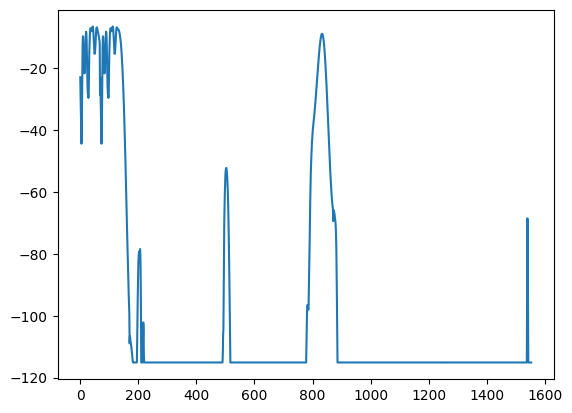

In [ ]:
plt.plot(modified_sortie["llikeli"])

In [ ]:
sum(modified_sortie["cum_l"] < a)

1554

In [ ]:
true_ranges

,maneuver,start_time,end_time
0,0,0.0,6.0
1,-1,6.0,7.7
2,17,7.7,40.8
3,-1,40.8,59.2
4,9,59.2,71.9
5,-1,71.9,92.3
6,7,92.3,155.1


In [ ]:
modified_sortie["likelihood"] = modified_sortie.drop(['maneuver'], axis=1).apply(multivariate_normal.pdf, axis=1, args=(hyp_SLUF_mu, hyp_SLUF_cov))
modified_sortie.loc[modified_sortie["likelihood"] < 10e-3, "log_likelihood"] = np.log(modified_sortie["likelihood"] < 10e-3)

modified_sortie["log_likelihood"].replace(-float('inf'), 1e-10, inplace=True)

KeyError: 'log_likelihood'

#THIS IS THE END FOR NOW

# To do

*   Difference of Means Squential
*   Kaulman Filter

In [ ]:
#Obtain MVG Parameters for Maneuvers
hyp_maneuver_cov = []
hyp_maneuver_mu = []

for maneuver in maneuvers[1:]:
  hyp_ALT = calc_speed(maneuver.copy())
  hyp_ALT = delta_heading(hyp_ALT)

  hyp_maneuver_cov.append(hyp_ALT[["speed","pitch","roll", "partial_heading"]].cov())
  hyp_maneuver_mu.append(hyp_ALT[["speed","pitch","roll", "partial_heading"]].mean())

Issues with current setup.

Hypothesis test may be picking up on the generated data/artifacts. If so, this is VERY bad. Maybe adding noise may help?

The problem is not very diffucult (could be likely).

I need to test some real data and see how it perfoms (i.e. make a testing set)